# Environment creation

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, avg, round
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType, IntegerType

In [2]:
spark = SparkSession.builder.appName("BigDataProject").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/07 10:52:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option('header', True).csv('/home/olzhasalimseitov/anaconda3/envs/big_data_project/weather/weather_kz.csv')

In [4]:
df.show()

+------+----+-----+----+-------------+---------------+-----------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-----------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  06|   02|2018|  малооблачно|       пасмурно|   пасмурно|           ясно|      -19°|        -20°|    -14°|        -11°|        766|          766|      780|          780|      75%|        85%|    84%|        85%|
|Astana|  05|   02|2018|     пасмурно|       пасмурно|малооблачно|           ясно|      -23°|        -26°|    -16°| 

# Data pre-processing

In [5]:
df.dropDuplicates(['weather_night']).select('weather_night').show()

+---------------+
|  weather_night|
+---------------+
|          дождь|
|           смог|
|           снег|
|          туман|
|        облачно|
|       пасмурно|
|          гроза|
|небольшой дождь|
|    малооблачно|
|           пыль|
|   легкий туман|
|           ясно|
+---------------+



In [6]:
translator = {
    'дождь': 'rainy',
    'смог': 'smoggy',
    'снег': 'snowy',
    'туман': 'foggy',
    'облачно': 'cloudy',
    'пасмурно': 'overcast',
    'гроза': 'stormy',
    'небольшой дождь': 'light rain',
    'малооблачно': 'partly cloudy',
    'пыль': 'dusty',
    'легкий туман': 'light fog',
    'ясно': 'clear',
}

df = df.replace(to_replace=translator, subset=['weather_night', 'weather_morning', 'weather_day', 'weather_evening'])

In [7]:
df.dropDuplicates(['weather_morning']).select('weather_morning').show()

+---------------+
|weather_morning|
+---------------+
|          rainy|
|          dusty|
|          snowy|
|      light fog|
|         stormy|
|  partly cloudy|
|     light rain|
|          clear|
|         cloudy|
|         smoggy|
|       overcast|
|          foggy|
+---------------+



In [8]:
print(f'Shape: ({df.count()}, {len(df.columns)})')

Shape: (35140, 20)


In [9]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|      -19°|        -20°|    -14°|        -11°|        766|          766|      780|          780|      75%|        85%|    84%|        85%|
|Astana|  05|   02|2018|     overcast|       overcast|partly cloudy|          clear|      -23°|        -26°|

In [10]:
print(*set([df.select('city').where(col(column).isNull()).count() for column in df.columns]))

0


In [11]:
def temperature_formatter(temp):
    if temp[0] == '+':
      return temp[1:-1]
    elif temp[0] == '-':
      return temp[:-1]
    return temp[0]
udf_temperature_formmater = udf(lambda x: temperature_formatter(x), StringType())

In [12]:
df.select(udf_temperature_formmater(col('temp_night')).alias('temp_night')).show()

+----------+
|temp_night|
+----------+
|       -19|
|       -23|
|       -13|
|       -14|
|       -20|
|       -24|
|       -25|
|       -13|
|       -12|
|       -22|
|       -16|
|       -17|
|       -14|
|       -12|
|       -15|
|       -16|
|       -10|
|        -7|
|       -14|
|       -21|
+----------+
only showing top 20 rows



In [13]:
df.columns

['city',
 'date',
 'month',
 'year',
 'weather_night',
 'weather_morning',
 'weather_day',
 'weather_evening',
 'temp_night',
 'temp_morning',
 'temp_day',
 'temp_evening',
 'press_night',
 'press_morning',
 'press_day',
 'press_evening',
 'hum_night',
 'hum_morning',
 'hum_day',
 'hum_evening']

In [14]:
df = df.withColumn(
      'temp_night1', udf_temperature_formmater(df.temp_night)
      ).withColumn(
      'temp_morning1', udf_temperature_formmater(df.temp_morning)
      ).withColumn(
      'temp_day1', udf_temperature_formmater(df.temp_day)
      ).withColumn(
      'temp_evening1', udf_temperature_formmater(df.temp_evening)
      ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('temp_night1').alias('temp_night'),
        col('temp_morning1').alias('temp_morning'),
        col('temp_day1').alias('temp_day'),
        col('temp_evening1').alias('temp_evening'),
        'press_night',
        'press_morning',
        'press_day',
        'press_evening',
        'hum_night',
        'hum_morning',
        'hum_day',
        'hum_evening')

In [15]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|temp_night|temp_morning|temp_day|temp_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+----------+------------+--------+------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|       -19|         -20|     -14|         -11|        766|          766|      780|          780|      75%|        85%|    84%|        85%|
|Astana|  05|   02|2018|     overcast|       overcast|partly cloudy|          clear|       -23|         -26|

In [16]:
df.dropDuplicates(['temp_morning']).select('temp_morning').show()

+------------+
|temp_morning|
+------------+
|          -4|
|         -30|
|           7|
|          -1|
|          15|
|          -6|
|          11|
|          29|
|         -39|
|           3|
|          30|
|          34|
|           8|
|          -7|
|          22|
|          28|
|          16|
|          35|
|         -22|
|           0|
+------------+
only showing top 20 rows



In [17]:
def humidity_formatter(hum):
    return hum[:-1]
udf_thumidity_formmater = udf(lambda x: humidity_formatter(x), StringType())

In [18]:
df = df.withColumn(
      'hum_night1', udf_thumidity_formmater(df.hum_night)
      ).withColumn(
      'hum_morning1', udf_thumidity_formmater(df.hum_morning)
      ).withColumn(
      'hum_day1', udf_thumidity_formmater(df.hum_day)
      ).withColumn(
      'hum_evening1', udf_thumidity_formmater(df.hum_evening)
      ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('hum_night1').alias('hum_night'),
        col('hum_morning1').alias('hum_morning'),
        col('hum_day1').alias('hum_day'),
        col('hum_evening1').alias('hum_evening'),
        'press_night',
        'press_morning',
        'press_day',
        'press_evening',
        'temp_night',
        'temp_morning',
        'temp_day',
        'temp_evening')

In [19]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+---------+-----------+-------+-----------+-----------+-------------+---------+-------------+----------+------------+--------+------------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|hum_night|hum_morning|hum_day|hum_evening|press_night|press_morning|press_day|press_evening|temp_night|temp_morning|temp_day|temp_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+---------+-----------+-------+-----------+-----------+-------------+---------+-------------+----------+------------+--------+------------+
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|       75|         85|     84|         85|        766|          766|      780|          780|       -19|         -20|     -14|         -11|
|Astana|  05|   02|2018|     overcast|       overcast|partly cloudy|          clear|       91|         83|  

In [20]:
df = df.withColumn(
    "hum_night1", df.hum_night.cast(IntegerType())
    ).withColumn(
    "hum_morning1", df.hum_morning.cast(IntegerType())
    ).withColumn(
    "hum_day1", df.hum_day.cast(IntegerType())
    ).withColumn(
    "hum_evening1", df.hum_evening.cast(IntegerType())
    ).withColumn(
    "press_night1", df.press_night.cast(IntegerType())
    ).withColumn(
    "press_morning1", df.press_morning.cast(IntegerType())
    ).withColumn(
    "press_day1", df.press_day.cast(IntegerType())
    ).withColumn(
    "press_evening1", df.press_evening.cast(IntegerType())
    ).withColumn(
    "temp_night1", df.temp_night.cast(IntegerType())
    ).withColumn(
    "temp_morning1", df.temp_morning.cast(IntegerType())
    ).withColumn(
    "temp_day1", df.temp_day.cast(IntegerType())
    ).withColumn(
    "temp_evening1", df.temp_evening.cast(IntegerType())
    ).select('city',
        'date',
        'month',
        'year',
        'weather_night',
        'weather_morning',
        'weather_day',
        'weather_evening',
        col('press_night1').alias('press_night'),
        col('press_morning1').alias('press_morning'),
        col('press_day1').alias('press_day'),
        col('press_evening1').alias('press_evening'),
        col('hum_night1').alias('hum_night'),
        col('hum_morning1').alias('hum_morning'),
        col('hum_day1').alias('hum_day'),
        col('hum_evening1').alias('hum_evening'),
        col('temp_night1').alias('temp_night'),
        col('temp_morning1').alias('temp_morning'),
        col('temp_day1').alias('temp_day'),
        col('temp_evening1').alias('temp_evening'),
    )

In [21]:
df.show()

+------+----+-----+----+-------------+---------------+-------------+---------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+----------+------------+--------+------------+
|  city|date|month|year|weather_night|weather_morning|  weather_day|weather_evening|press_night|press_morning|press_day|press_evening|hum_night|hum_morning|hum_day|hum_evening|temp_night|temp_morning|temp_day|temp_evening|
+------+----+-----+----+-------------+---------------+-------------+---------------+-----------+-------------+---------+-------------+---------+-----------+-------+-----------+----------+------------+--------+------------+
|Astana|  06|   02|2018|partly cloudy|       overcast|     overcast|          clear|        766|          766|      780|          780|       75|         85|     84|         85|       -19|         -20|     -14|         -11|
|Astana|  05|   02|2018|     overcast|       overcast|partly cloudy|          clear|        771|          77

# Analysis

Average atmospheric pressure in Kazakhstan at different times of day

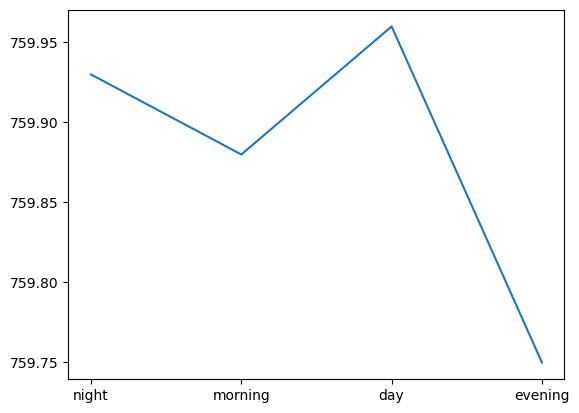

In [69]:
avg_press_by_time = df.select(
    round(avg(col('press_night')), 2).alias('night'),
    round(avg(col('press_morning')), 2).alias('morning'),
    round(avg(col('press_day')), 2).alias('day'),
    round(avg(col('press_evening')), 2).alias('evening')).toPandas()
plt.plot(list(avg_press_by_time.columns), avg_press_by_time.values.tolist()[0])
plt.show()

Average humidity in Kazakhstan at different times of day

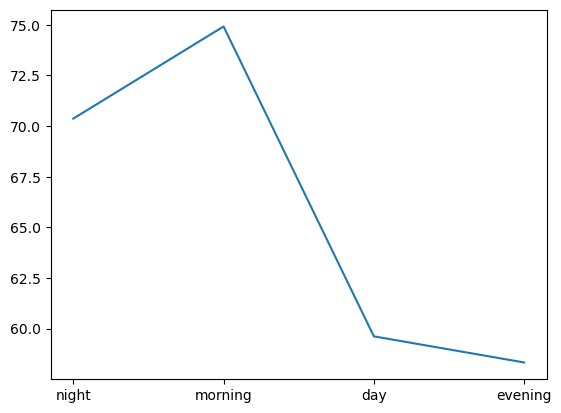

In [72]:
avg_hum_by_time = df.select(
    round(avg(col('hum_night')), 2).alias('night'),
    round(avg(col('hum_morning')), 2).alias('morning'),
    round(avg(col('hum_day')), 2).alias('day'),
    round(avg(col('hum_evening')), 2).alias('evening')).toPandas()
plt.plot(list(avg_hum_by_time.columns), avg_hum_by_time.values.tolist()[0])
plt.show()

Average temperature pressure in Kazakhstan at different times of day

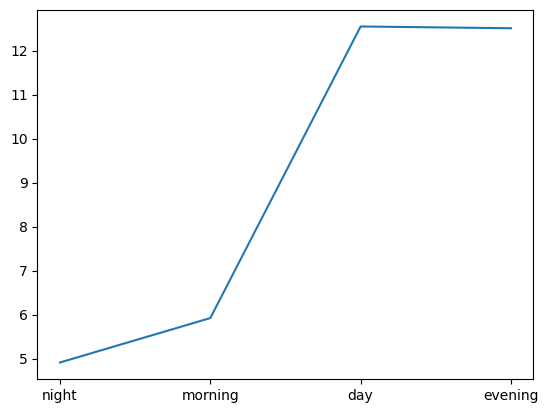

In [73]:
avg_temp_by_time = df.select(
    round(avg(col('temp_night')), 2).alias('night'),
    round(avg(col('temp_morning')), 2).alias('morning'),
    round(avg(col('temp_day')), 2).alias('day'),
    round(avg(col('temp_evening')), 2).alias('evening')).toPandas()
plt.plot(list(avg_temp_by_time.columns), avg_temp_by_time.values.tolist()[0])
plt.show()

Average atmospheric presssure by cities at different times of day

In [23]:
presses = ['press_night', 'press_morning', 'press_day', 'press_evening']
for press in presses:
    print(press)
    df.select('city', press).groupBy('city').agg(round(avg(press), 2).alias('AVG')).orderBy('AVG').show()

press_night
+-----------+------+
|       city|   AVG|
+-----------+------+
|Taldykorgan|745.63|
|    Konayev|745.63|
|     Almaty|745.63|
|     Astana|760.75|
|  Kokshetau|760.75|
|   Shymkent|761.12|
|  Turkestan|761.12|
|      Taraz|761.71|
|  Petropavl|762.07|
|      Aktau|762.37|
|  Kyzylorda|762.45|
|   Kostanay|762.46|
|     Atyrau|762.72|
|       Oral|762.76|
|     Aktobe|762.96|
|   Pavlodar| 763.3|
|  karaganda|763.52|
|  Jezkazgan|763.52|
|      Semey|764.08|
|    Oskemen|764.08|
+-----------+------+

press_morning
+-----------+------+
|       city|   AVG|
+-----------+------+
|Taldykorgan|745.71|
|    Konayev|745.71|
|     Almaty|745.71|
|     Astana|761.01|
|  Kokshetau|761.01|
|   Shymkent|761.03|
|  Turkestan|761.03|
|      Taraz|761.65|
|  Petropavl|761.94|
|      Aktau|762.02|
|   Kostanay|762.18|
|  Kyzylorda|762.31|
|     Atyrau|762.48|
|       Oral| 762.6|
|     Aktobe|762.79|
|   Pavlodar|763.23|
|  karaganda|763.39|
|  Jezkazgan|763.39|
|      Semey| 764.2|
|    Os

Average humidity by cities at different times of day

In [24]:
humes = ['hum_night', 'hum_morning', 'hum_day', 'hum_evening']
for hum in humes:
    print(hum)
    df.select('city', hum).groupBy('city').agg(round(avg(hum), 2).alias('AVG')).orderBy('AVG').show()

hum_night
+-----------+-----+
|       city|  AVG|
+-----------+-----+
|  Kyzylorda|59.01|
|    Konayev|60.72|
|     Almaty|60.72|
|Taldykorgan|60.72|
|  Turkestan|61.75|
|   Shymkent|61.75|
|      Aktau|64.18|
|     Atyrau|64.68|
|      Taraz|66.26|
|     Aktobe|69.18|
|       Oral|73.24|
|  Jezkazgan|76.49|
|  karaganda|76.49|
|   Kostanay|77.04|
|     Astana|77.99|
|  Kokshetau|77.99|
|   Pavlodar|78.22|
|      Semey|80.18|
|    Oskemen|80.18|
|  Petropavl|80.49|
+-----------+-----+

hum_morning
+-----------+-----+
|       city|  AVG|
+-----------+-----+
|Taldykorgan|61.75|
|    Konayev|61.75|
|     Almaty|61.75|
|  Turkestan|66.91|
|   Shymkent|66.91|
|  Kyzylorda|67.14|
|      Aktau|69.23|
|      Taraz|70.83|
|     Atyrau|72.24|
|     Aktobe|76.27|
|  karaganda| 79.2|
|  Jezkazgan| 79.2|
|       Oral|81.31|
|   Kostanay|82.22|
|     Astana|82.51|
|  Kokshetau|82.51|
|   Pavlodar|82.64|
|      Semey|84.39|
|    Oskemen|84.39|
|  Petropavl|85.12|
+-----------+-----+

hum_day
+-------

In [25]:
temps = ['temp_night', 'temp_morning', 'temp_day', 'temp_evening']
for temp in temps:
    print(temp)
    df.select('city', temp).groupBy('city').agg(round(avg(temp), 2).alias('AVG')).orderBy('AVG').show()

temp_night
+-----------+-----+
|       city|  AVG|
+-----------+-----+
|  Jezkazgan|-0.34|
|  karaganda|-0.34|
|      Semey| 0.81|
|    Oskemen| 0.81|
|   Pavlodar| 1.32|
|  Petropavl| 1.35|
|     Astana| 1.41|
|  Kokshetau| 1.41|
|   Kostanay| 1.98|
|     Aktobe| 4.49|
|       Oral| 5.07|
|     Almaty| 6.02|
|    Konayev| 6.02|
|Taldykorgan| 6.02|
|  Kyzylorda| 8.79|
|      Taraz| 8.98|
|     Atyrau| 9.65|
|      Aktau|11.27|
|  Turkestan|11.72|
|   Shymkent|11.72|
+-----------+-----+

temp_morning
+-----------+-----+
|       city|  AVG|
+-----------+-----+
|  Jezkazgan| 1.45|
|  karaganda| 1.45|
|   Kostanay| 2.17|
|  Petropavl| 2.19|
|     Astana| 2.61|
|  Kokshetau| 2.61|
|   Pavlodar| 2.68|
|      Semey| 2.69|
|    Oskemen| 2.69|
|     Aktobe| 3.76|
|       Oral| 4.36|
|  Kyzylorda| 8.12|
|     Atyrau|  8.7|
|    Konayev| 9.65|
|     Almaty| 9.65|
|Taldykorgan| 9.65|
|      Taraz| 9.71|
|      Aktau| 10.6|
|  Turkestan|11.84|
|   Shymkent|11.84|
+-----------+-----+

temp_day
+----

In [26]:
presses = ['press_night', 'press_morning', 'press_day', 'press_evening']
for press in presses:
    df.select('month', press).groupBy('month').agg(round(avg(press), 2).alias('AVG')).orderBy('AVG').show()

+-----+------+
|month|   AVG|
+-----+------+
|   07|752.58|
|   06|754.25|
|   08|755.13|
|   05|757.85|
|   09| 759.0|
|   04|760.15|
|   03|761.17|
|   02|761.79|
|   10|763.76|
|   01|763.77|
|   11|765.75|
|   12|766.28|
+-----+------+

+-----+------+
|month|   AVG|
+-----+------+
|   07|752.74|
|   06| 754.3|
|   08|755.23|
|   05|757.98|
|   09| 759.1|
|   04|760.06|
|   03|761.04|
|   02|761.59|
|   01|763.44|
|   10|763.71|
|   11|765.49|
|   12|766.07|
+-----+------+

+-----+------+
|month|   AVG|
+-----+------+
|   07|752.75|
|   06|754.22|
|   08|755.27|
|   05|757.89|
|   09|759.19|
|   04|760.31|
|   03|761.13|
|   02|761.88|
|   01|763.46|
|   10|763.75|
|   11|765.77|
|   12|766.11|
+-----+------+

+-----+------+
|month|   AVG|
+-----+------+
|   07|752.26|
|   06|753.81|
|   08|754.85|
|   05|757.35|
|   09|758.92|
|   04|759.89|
|   03|760.95|
|   02|761.83|
|   01|763.53|
|   10|763.63|
|   12|766.14|
|   11|766.15|
+-----+------+



In [27]:
temps = ['temp_night', 'temp_morning', 'temp_day', 'temp_evening']
for temp in temps:
    df.select('month', temp).groupBy('month').agg(round(avg(temp), 2).alias('AVG')).orderBy('AVG').show()

+-----+-----+
|month|  AVG|
+-----+-----+
|   01|-9.52|
|   12|-8.68|
|   02|-8.67|
|   11|-4.06|
|   03|-2.69|
|   10| 4.83|
|   04| 6.01|
|   09|11.01|
|   05|11.98|
|   06|16.07|
|   08|16.84|
|   07|19.03|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   01|-9.19|
|   02|-8.44|
|   12|-8.36|
|   11|-3.87|
|   03|-2.46|
|   10| 4.96|
|   04| 6.84|
|   09|11.59|
|   05|14.18|
|   08|18.37|
|   06|18.83|
|   07|21.51|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   01|-5.66|
|   12|-4.82|
|   02| -3.6|
|   11| 0.48|
|   03| 2.87|
|   10| 12.6|
|   04|14.59|
|   09|20.41|
|   05|22.21|
|   06|26.18|
|   08|27.38|
|   07|29.52|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   01|-6.28|
|   12|-5.78|
|   02|-3.56|
|   11|-0.38|
|   03| 3.14|
|   10|12.17|
|   04|14.97|
|   09|20.58|
|   05|22.56|
|   06|26.36|
|   08|27.78|
|   07|29.76|
+-----+-----+



In [28]:
humes = ['hum_night', 'hum_morning', 'hum_day', 'hum_evening']
for hum in humes:
    df.select('month', hum).groupBy('month').agg(round(avg(hum), 2).alias('AVG')).orderBy('AVG').show()

+-----+-----+
|month|  AVG|
+-----+-----+
|   09|59.49|
|   08|59.52|
|   07|59.71|
|   06|60.54|
|   05|62.11|
|   10|67.14|
|   04|71.54|
|   11| 79.0|
|   03|82.48|
|   12|82.48|
|   02|82.55|
|   01|83.89|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   07|65.63|
|   06|66.02|
|   08|66.04|
|   09|66.29|
|   05|68.32|
|   10|72.96|
|   04|76.82|
|   11|82.02|
|   12|84.11|
|   02|84.55|
|   01|85.27|
|   03|85.59|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   07| 40.8|
|   06|40.94|
|   08|42.18|
|   05|43.23|
|   09|45.51|
|   10|55.56|
|   04|55.74|
|   11|75.59|
|   03|77.43|
|   02|82.72|
|   12| 83.0|
|   01|84.05|
+-----+-----+

+-----+-----+
|month|  AVG|
+-----+-----+
|   08|39.26|
|   07|39.52|
|   06|40.09|
|   05|41.27|
|   09|42.99|
|   04|52.94|
|   10|55.58|
|   03|75.57|
|   11|75.64|
|   02|80.99|
|   12|83.18|
|   01|84.98|
+-----+-----+



In [31]:
temps = ['temp_night', 'temp_morning', 'temp_day', 'temp_evening']
for temp in temps:
    df.select('year', temp).where(col('year') < 2022).groupBy('year').agg(round(avg(temp), 2).alias('AVG')).orderBy('year').show()

+----+----+
|year| AVG|
+----+----+
|2018|4.06|
|2019|4.55|
|2020|5.06|
|2021|4.58|
+----+----+

+----+----+
|year| AVG|
+----+----+
|2018|5.36|
|2019| 5.5|
|2020|5.91|
|2021|5.52|
+----+----+

+----+-----+
|year|  AVG|
+----+-----+
|2018|12.11|
|2019|12.05|
|2020|12.52|
|2021| 12.0|
+----+-----+

+----+-----+
|year|  AVG|
+----+-----+
|2018|12.11|
|2019|11.92|
|2020|12.43|
|2021| 12.0|
+----+-----+



In [32]:
df.select('month', hum).groupBy('month').agg(round(avg(hum), 2).alias('AVG')).orderBy('AVG').show()

+-----+-----+
|month|  AVG|
+-----+-----+
|   08|39.26|
|   07|39.52|
|   06|40.09|
|   05|41.27|
|   09|42.99|
|   04|52.94|
|   10|55.58|
|   03|75.57|
|   11|75.64|
|   02|80.99|
|   12|83.18|
|   01|84.98|
+-----+-----+



In [33]:
temps = ['temp_night', 'temp_morning', 'temp_day', 'temp_evening']
for hum in humes:
    df.select('year', hum).where(col('year') < 2022).groupBy('year').agg(round(avg(hum), 2).alias('AVG')).orderBy('year').show()

+----+-----+
|year|  AVG|
+----+-----+
|2018|74.87|
|2019|71.62|
|2020|70.06|
|2021|67.62|
+----+-----+

+----+-----+
|year|  AVG|
+----+-----+
|2018| 78.9|
|2019|76.42|
|2020|74.77|
|2021|72.04|
+----+-----+

+----+-----+
|year|  AVG|
+----+-----+
|2018|64.21|
|2019|61.91|
|2020| 59.2|
|2021|57.02|
+----+-----+

+----+-----+
|year|  AVG|
+----+-----+
|2018| 54.0|
|2019|61.49|
|2020|59.52|
|2021|58.75|
+----+-----+



In [34]:
df.groupBy('weather_night').count().orderBy('count').show()

+-------------+-----+
|weather_night|count|
+-------------+-----+
|    light fog|    5|
|   light rain|   27|
|        dusty|   32|
|       stormy|   42|
|       smoggy|  110|
|        rainy| 1339|
|        snowy| 1369|
|       cloudy| 1614|
|        foggy| 2291|
|partly cloudy| 3035|
|     overcast|11529|
|        clear|13747|
+-------------+-----+



In [35]:
weathers = df.groupBy('weather_night').count().orderBy('count').toPandas()

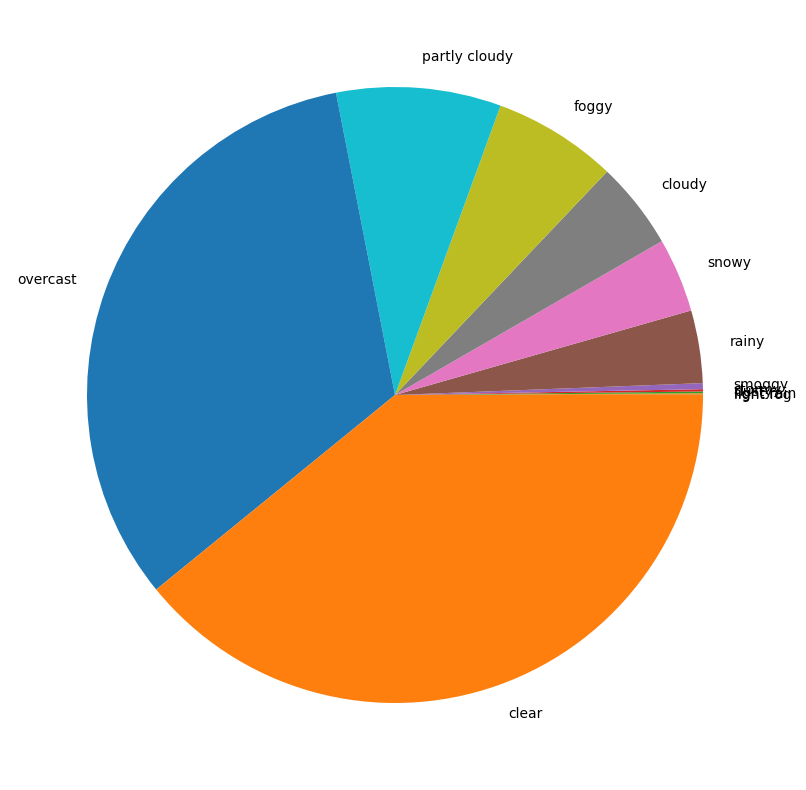

In [36]:
fig = plt.figure(figsize =(10, 10))
plt.pie(weathers['count'], labels=weathers['weather_night'])
plt.show()

In [37]:
weathers_day = df.groupBy('weather_day').count().orderBy('count').toPandas()

In [38]:
weathers_day

,weather_day,count
0,light fog,8
1,stormy,9
2,light rain,12
3,dusty,25
4,smoggy,50
5,rainy,652
6,foggy,994
7,snowy,1092
8,cloudy,1555
9,partly cloudy,3593


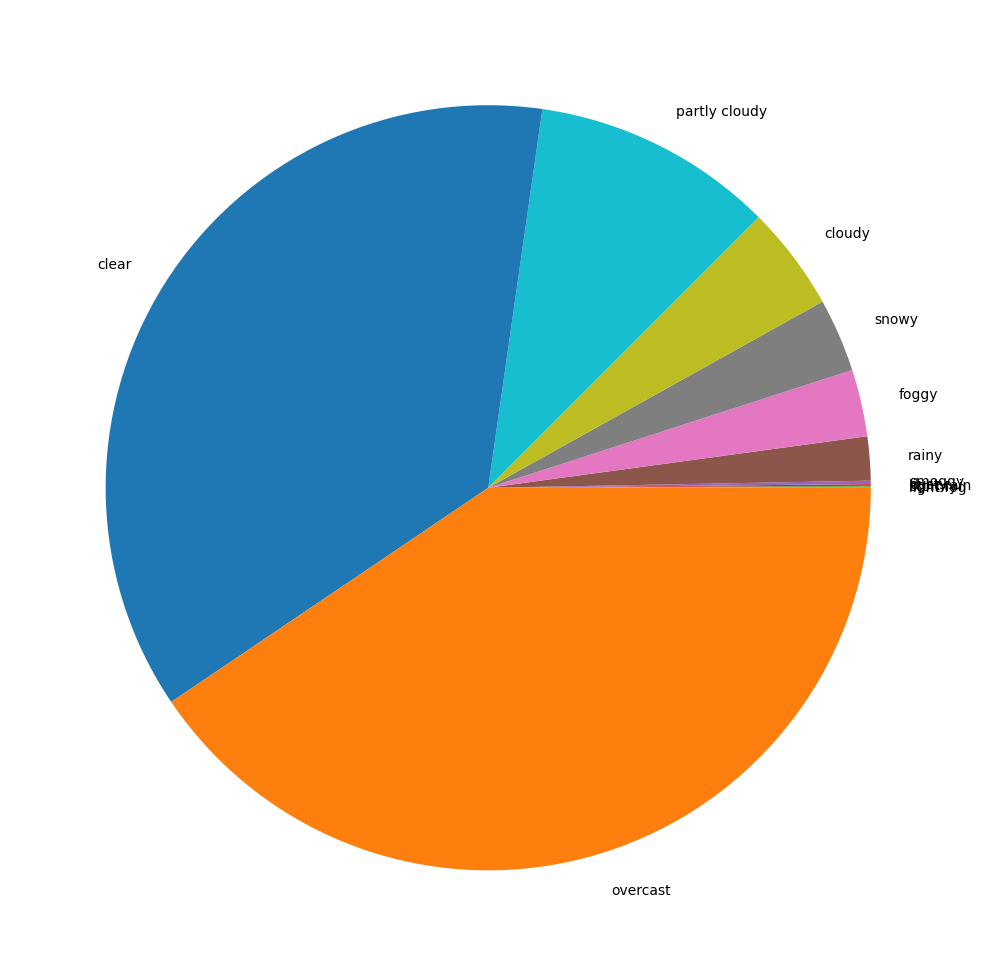

In [39]:
fig = plt.figure(figsize =(10, 10))
plt.pie(weathers_day['count'], labels=weathers_day['weather_day'])
plt.tight_layout()
plt.show()

In [40]:
df.select('weather_day', 'hum_day').groupBy('weather_day').agg(round(avg('hum_day'), 2).alias('AVG')).orderBy('avg').show()

+-------------+-----+
|  weather_day|  AVG|
+-------------+-----+
|        dusty|39.04|
|    light fog| 39.5|
|        clear|47.67|
|       cloudy| 54.4|
|partly cloudy|56.06|
|       stormy|64.44|
|     overcast|66.14|
|       smoggy| 70.2|
|        rainy|84.87|
|        snowy|90.05|
|        foggy|91.94|
|   light rain|98.83|
+-------------+-----+



In [41]:
df.select('weather_day', 'temp_day').groupBy('weather_day').agg(round(avg('temp_day'), 2).alias('AVG')).orderBy('avg').show()

+-------------+-----+
|  weather_day|  AVG|
+-------------+-----+
|        snowy|-5.18|
|        foggy|-4.64|
|       smoggy|  3.8|
|   light rain| 5.08|
|     overcast|10.76|
|        rainy|10.82|
|       cloudy|13.58|
|partly cloudy| 14.9|
|        dusty|15.84|
|    light fog| 16.0|
|        clear|16.69|
|       stormy|25.44|
+-------------+-----+

